In [1]:
"""ResNet Train/Eval module.
"""
import time
import six
import sys
import os

import cifar_input
import numpy as np
import resnet_model
# import vgg_preprocessing
import imagenet_predict_preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import re
import resnet_model_official
os.environ["CUDA VISIBLE DEVICES"]="5"

In [2]:
_DEFAULT_IMAGE_SIZE = 224
_NUM_CHANNELS = 3
#_LABEL_CLASSES = 1001
_LABEL_CLASSES = 1000

_MOMENTUM = 0.9
_WEIGHT_DECAY = 1e-4

_NUM_IMAGES = {
    'train': 1281167,
    'validation': 50000,
}

_FILE_SHUFFLE_BUFFER = 1024
_SHUFFLE_BUFFER = 1500

data_format = 'channels_last'

In [4]:
def filenames(is_training, data_dir):
  """Return filenames for dataset."""
  if is_training:
    return [
        os.path.join(data_dir, 'train-%05d-of-01024' % i)
        for i in range(1024)]
  else:
    return [
        os.path.join(data_dir, 'validation-%05d-of-00128' % i)
        for i in range(128)]

In [14]:
def record_parser(value, is_training):
    """Parse an ImageNet record from `value`."""
    keys_to_features = {
      'image/encoded':
          tf.FixedLenFeature((), tf.string, default_value=''),
      'image/format':
          tf.FixedLenFeature((), tf.string, default_value='jpeg'),
      'image/class/label':
          tf.FixedLenFeature([], dtype=tf.int64, default_value=-1),
      'image/class/text':
          tf.FixedLenFeature([], dtype=tf.string, default_value=''),
      'image/object/bbox/xmin':
          tf.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymin':
          tf.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/xmax':
          tf.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymax':
          tf.VarLenFeature(dtype=tf.float32),
      'image/object/class/label':
          tf.VarLenFeature(dtype=tf.int64),
    }

    parsed = tf.parse_single_example(value, keys_to_features)

    image = tf.image.decode_image(
      tf.reshape(parsed['image/encoded'], shape=[]),
      _NUM_CHANNELS)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    
    #image = vgg_preprocessing.preprocess_image(
    image_raw,image_pre = imagenet_predict_preprocessing.preprocess_image(
      image=image,
      output_height=_DEFAULT_IMAGE_SIZE,
      output_width=_DEFAULT_IMAGE_SIZE,
      is_training=is_training)

    label_raw = tf.cast(
      tf.reshape(parsed['image/class/label'], shape=[]),
      dtype=tf.int32)
    
    label_pre = tf.one_hot(label_raw,_LABEL_CLASSES)
    
    text=tf.cast(
      tf.reshape(parsed['image/class/text'], shape=[]),
      dtype=tf.string)
    
    return image_raw,label_raw,text,image_pre,label_pre

#     return image, tf.one_hot(label, _LABEL_CLASSES)


def input_fn(is_training, data_dir, batch_size, num_epochs=1):
    """Input function which provides batches for train or eval."""
    #dataset = tf.contrib.data.Dataset.from_tensor_slices(filenames(is_training, data_dir))
    dataset = tf.data.Dataset.from_tensor_slices(filenames(is_training, data_dir))
    if is_training:
        dataset = dataset.shuffle(buffer_size=_FILE_SHUFFLE_BUFFER)

    #dataset = dataset.flat_map(tf.contrib.data.TFRecordDataset)
    dataset = dataset.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(lambda value: record_parser(value, is_training),
                        # num_threads=5,
                        # output_buffer_size=batch_size)
                        num_parallel_calls=num_parallel_calls)
    # dataset = dataset.prefetch(batch_size)

    if is_training:
        # When choosing shuffle buffer sizes, larger sizes result in better
        # randomness, while smaller sizes have better performance.
        dataset = dataset.shuffle(buffer_size=_SHUFFLE_BUFFER)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    images_raw, labels_raw,texts,images_pre,labels_pre = iterator.get_next()
    
#     def count():
#         i =0
#         while True:
#             yield(i)
#             i=i+1
#     counter = iter(count())
#     print('Out the {0} time data'.format(next(counter)))
    
    return images_raw, labels_raw,texts,images_pre,labels_pre

In [8]:
eval_data_path="/home/hdd0/dataset/imagenet2012/ILSVRC2012"

#checkpoint_dir

train_dir="/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt"
#log_dir
log_dir="/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-log"
#eval_dir
eval_dir="/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-eval"

batch_size=10
num_parallel_calls=5

In [9]:
class ResNet(object):
    """ResNet model."""

    def __init__(self, hps, images, labels, mode):
        '''
        ResNet constructor.
        Args:
          hps: Hyperparameters.
          images: Batches of images. [batch_size, image_size, image_size, 3]
          labels: Batches of labels. [batch_size, num_classes]
          mode: One of 'train' and 'eval'.
        '''
        self.hps = hps
        self._images = images
        self.labels = labels
        self.mode = mode

        self._extra_train_ops = []

    def build_graph(self, istrain=True):
        """Build a whole graph for the model."""
        self.global_step = tf.train.get_or_create_global_step()
        self._build_model(istrain)
        if self.mode == 'train':
            self._build_train_op()
        self.summaries = tf.summary.merge_all()

    def _build_model(self, istrain):
        """Build the core model within the graph."""
        if dataset == 'cifar10':
            network = resnet_model_official.cifar10_resnet_v2_generator(resnet_size=50,
                                                                        num_classes=self.hps.num_classes,
                                                                        data_format=data_format)
        elif dataset == 'imagenet':
            network = resnet_model_official.imagenet_resnet_v2(resnet_size=50, num_classes=self.hps.num_classes,
                                                               data_format=data_format)

        logits = network(self._images, istrain)
        self.predictions = tf.nn.softmax(logits)
        cross_entropy = tf.losses.softmax_cross_entropy(
            logits=logits, onehot_labels=self.labels
        )
        tf.identity(cross_entropy, name='cross_entropy')
        tf.summary.scalar('cross_entropy', cross_entropy)

        # Add weight decay to the loss.
        self.cost = cross_entropy + self.hps.weight_decay_rate * tf.add_n(
            [tf.nn.l2_loss(v) for v in tf.trainable_variables()])

        tf.summary.scalar('cost', self.cost)

In [10]:
#generatin the imagenet1000_clsidx_to_labels
imagenet1000_clsidx_to_labels={}
with open('imagenet1000_clsidx_to_labels.txt') as file:
    pattern= re.compile(r"{?\s*([\d]+)\:[\s]*['|\"]([\w,\s\-\'.]+)(['|\"],\n|})$")
    file = file.readlines()
    for line in file:
        matched = re.match(pattern,line)
        key= int(matched.group(1))
        value=matched.group(2)
        imagenet1000_clsidx_to_labels[key]=value
#     print(imagenet1000_clsidx_to_labels)
print(len(imagenet1000_clsidx_to_labels))

1000


In [11]:
num_classes=1000
dataset='imagenet'
hps = resnet_model.HParams(num_classes=num_classes,\
                         lrn_rate=0.1,
                         weight_decay_rate = 0.0002,
                         optimizer='mom')

Out the 0 time data
INFO:tensorflow:Loading checkpoint from  /Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt and the ckpt_state is model_checkpoint_path: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-106816"
all_model_checkpoint_paths: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-105357"
all_model_checkpoint_paths: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-105701"
all_model_checkpoint_paths: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-106071"
all_model_checkpoint_paths: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-106449"
all_model_checkpoint_paths: "/Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-106816"

INFO:tensorflow:Loading checkpoint /Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-106816
INFO:tensorflow:Restoring parameters from /Tensorflow/docker-multiple/ResNet/resnet50-imagenet-ckpt/model.ckpt-10681

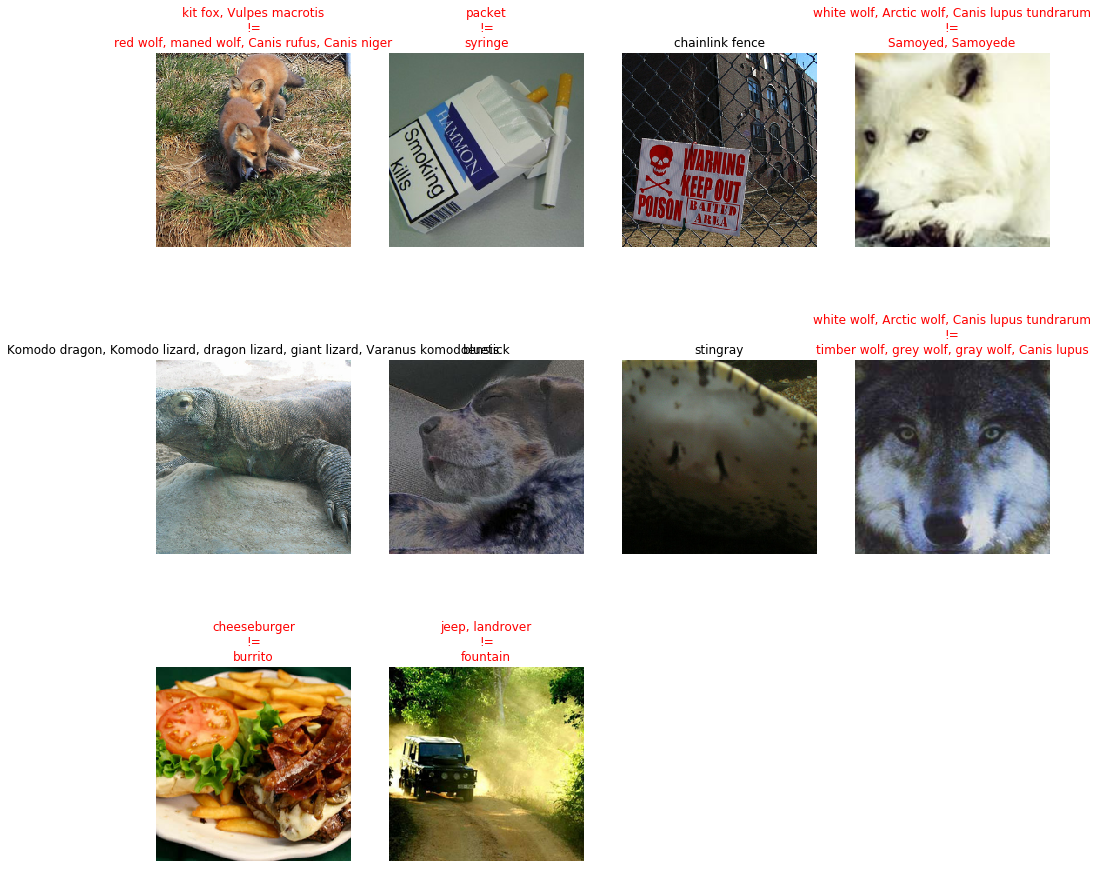

In [22]:
# def predict(hps=None):
tf.reset_default_graph()
g = tf.Graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True),graph=g) as sess:
    #get the tensor of data from tf.data API
    images_raw, labels_raw,texts,images_pre,labels_pre = input_fn('predict',eval_data_path, batch_size,num_epochs=1)

    #loading the unpreprocessed images and labels to visulization:
    #loading the preprocessed  images and labels to predict:
    images_value,labels_value,texts_value,images_pre_value,labels_pre_value = sess.run([images_raw,labels_raw, texts,images_pre,labels_pre])
    
    X = tf.placeholder(dtype=tf.float32, shape=(None, 224, 224, 3), name='X')
    Y = tf.placeholder(dtype=tf.float32, shape=(None, 1000), name='Y')  
    
    model = ResNet(hps, X, Y, mode='eval') 
    
    model.build_graph(istrain=False)
   
    saver = tf.train.Saver()
    
    tf.train.start_queue_runners(sess)
    
    try:
        ckpt_state = tf.train.get_checkpoint_state(train_dir)
        tf.logging.info('Loading checkpoint from  %s and the ckpt_state is %s' % (train_dir, ckpt_state))
    except tf.errors.OutOfRangeError as e:
        tf.logging.error('Cannot restore checkpoint: %s' % e)
    if not (ckpt_state and ckpt_state.model_checkpoint_path):
        tf.logging.info('No model to eval yet at %s' % train_dir)
    tf.logging.info('Loading checkpoint %s' % ckpt_state.model_checkpoint_path)
    saver.restore(sess, ckpt_state.model_checkpoint_path) 
    
    (summaries, loss, predictions, truth, train_step) = sess.run(
        [model.summaries, model.cost, model.predictions, model.labels, model.global_step],feed_dict={X:images_pre_value,Y:labels_pre_value})

    truth = np.argmax(truth, axis=1)
    predictions = np.argmax(predictions, axis=1)
    correct_num = np.sum(truth == predictions)
    precision = correct_num/batch_size
    tf.logging.info('The truth:{0},\nThe labels_raw:{1},\nThe prediction:{2},\nThe correct num:{3},\nThe precision:{4}\nThe labels_pre_value:{5}'
          .format(truth, labels_value, predictions, correct_num, precision,np.argmax(labels_pre_value,axis=1)))
    
    tf.logging.info('Display the image from the eval data')
    plt.figure(figsize=(16, 16))
    for index in range(batch_size):
        plt.subplot(math.ceil(batch_size /4),4,  index+1)
        plt.imshow(images_value[index])
        plt.axis('off')
        if truth[index]==predictions[index]:
            plt.title(imagenet1000_clsidx_to_labels[labels_value[index]-1])
        else:
            plt.title(imagenet1000_clsidx_to_labels[labels_value[index]-1] + '\n!=\n'+ imagenet1000_clsidx_to_labels[predictions[index]-1],color='red')
    plt.show()